In [ ]:
!git clone https://github.com/Emeika/image-deblur.git

Cloning into 'image-deblur'...
remote: Enumerating objects: 1814, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1814 (delta 5), reused 4 (delta 4), pack-reused 1805
Receiving objects: 100% (1814/1814), 65.59 MiB | 27.00 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
cd image-deblur/

/content/image-deblur


***Import Modules***

In [ ]:
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2D, UpSampling2D, Input, MaxPooling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint



In [ ]:
def load_and_preprocess_images(image_folder, label):
    data = []
    for file in tqdm(sorted(os.listdir(image_folder))):
        if any(file.endswith(extension) for extension in ['.jpg', '.JPG']):
            image_path = os.path.join(image_folder, file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
            image_flattened = image.flatten()  # Flatten the image
            image_flattened_str = ','.join(map(str, image_flattened))  # Convert to a single string
            data.append([image_path, image_flattened_str, label])  # Add image path and label
    return data

# Extract features
blur_features = load_and_preprocess_images('/content/image-deblur/resized_dataset/blur', label=0)
sharp_features = load_and_preprocess_images('/content/image-deblur/resized_dataset/sharp', label=1)

# Combine data and create a DataFrame
columns = ['image_path', 'image_features', 'label']
data = sharp_features + blur_features
features_df = pd.DataFrame(data, columns=columns)

# Save to CSV
features_df.to_csv('image_data.csv', index=False)


100%|██████████| 350/350 [00:09<00:00, 36.35it/s]


In [ ]:
def load_images_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    image_paths = df['image_path'].values
    labels = df['label'].values
    image_data = df['image_features'].apply(lambda x: np.fromstring(x, sep=',')).values
    images = np.array([img.reshape(128, 128, 3) for img in image_data])  # Reshape to original dimensions
    return images, image_paths, labels

# Load images from CSV
X, image_paths, y = load_images_from_csv('image_data.csv')

print(X.shape)  # Should be (num_images, 128, 128, 3)
print(image_paths.shape)  # Should be (num_images,)
print(y.shape)  # Should be (num_images,)


(700, 128, 128, 3)
(700,)
(700,)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from tqdm import tqdm

# Define the number of folds
num_folds = 5

# Initialize the KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store training and validation losses and metrics
train_losses = []
val_losses = []
train_maes = []
val_maes = []
image_shape = (128, 128, 3)

# Function to build the model
def build_model(input_shape):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
        BatchNormalization(),
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return model

# Image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Path to save the best model
best_model_path = 'best_deblur_model.h5'

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Training Fold {fold + 1}")

    # Get the data for this fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]

    # Reshape features to match image dimensions
    X_train_fold = X_train_fold.reshape(-1, *image_shape)
    X_val_fold = X_val_fold.reshape(-1, *image_shape)

    # Build the model
    model = build_model(image_shape)
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse'])

    # Define the ModelCheckpoint callback to save the best model based on validation loss
    checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

    # Train the model with data augmentation
    history = model.fit(
        datagen.flow(X_train_fold, X_train_fold, batch_size=16),
        steps_per_epoch=len(X_train_fold) // 16,
        epochs=50,
        validation_data=(X_val_fold, X_val_fold),
        callbacks=[checkpoint]
    )

    # Save training and validation losses and metrics
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_maes.append(history.history['mae'])
    val_maes.append(history.history['val_mae'])

# Convert lists to numpy arrays for easier calculation
average_train_loss = np.nanmean(train_losses_padded, axis=0)
average_val_loss = np.nanmean(val_losses_padded, axis=0)
average_train_mae = np.nanmean(train_maes_padded, axis=0)
average_val_mae = np.nanmean(val_maes_padded, axis=0)

# Print average training and validation losses and metrics across folds
print(f"Average Training Loss: {np.mean(train_losses, axis=0)}")
print(f"Average Validation Loss: {np.mean(val_losses, axis=0)}")
print(f"Average Training MAE: {np.mean(train_maes, axis=0)}")
print(f"Average Validation MAE: {np.mean(val_maes, axis=0)}")

# Load the best model for final use
best_model = load_model(best_model_path)


Training Fold 1
Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 0.0539 - mae: 0.1767 - mse: 0.0539
Epoch 1: val_loss improved from inf to 0.05395, saving model to best_deblur_model.h5
35/35 [==============================] - 7s 112ms/step - loss: 0.0539 - mae: 0.1767 - mse: 0.0539 - val_loss: 0.0540 - val_mae: 0.1908 - val_mse: 0.0540
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 0.0458 - mae: 0.1643 - mse: 0.0458
Epoch 2: val_loss did not improve from 0.05395
35/35 [==============================] - 4s 116ms/step - loss: 0.0458 - mae: 0.1643 - mse: 0.0458 - val_loss: 0.0609 - val_mae: 0.2091 - val_mse: 0.0609
Epoch 3/50
35/35 [==============================] - ETA: 0s - loss: 0.0429 - mae: 0.1580 - mse: 0.0429
Epoch 3: val_loss did not improve from 0.05395
35/35 [==============================] - 5s 143ms/step - loss: 0.0429 - mae: 0.1580 - mse: 0.0429 - val_loss: 0.0566 - val_mae: 0.2020 - val_mse: 0.0566
Epoch 4/50
35/35 [===================

In [ ]:
# Load the trained model
model = load_model('/content/image-deblur/best_deblur_model.h5')

def deblur_image(img_path, size=(128, 128)):
    # Load and preprocess the input image
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    deblurred_array = model.predict(img_array)[0]

    # Rescale the deblurred array to 0-255 and convert it to image
    deblurred_array = (deblurred_array * 255).astype('uint8')
    deblurred_img = array_to_img(deblurred_array)

    # Plot both images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Blurred Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(deblurred_img)
    plt.title('Deblurred Image')
    plt.axis('off')

    plt.show()

# Example usage
deblur_image('/content/42_NIKON-D3400-35MM_F.JPG')
deblur_image('/content/images.jpeg')
deblur_image('/content/52_HONOR-8X_F.jpg')
deblur_image('/content/Untitled.jpeg')



Way 2

In [ ]:
# Define the number of folds
num_folds = 5

# Initialize the KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []
image_shape = (128, 128, 3)

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Training Fold {fold + 1}")

    # Get the data for this fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]

    # Reshape features to match image dimensions
    X_train_fold = X_train_fold.reshape(-1, *image_shape)
    X_val_fold = X_val_fold.reshape(-1, *image_shape)

    # Build the model
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=image_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])

    model.compile(optimizer=Adam(), loss='mean_squared_error')
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # batch size = 32

    # Train the model
    history = model.fit(X_train_fold, X_train_fold, epochs=50, batch_size=16, validation_data=(X_val_fold, X_val_fold))

    # Save training and validation losses
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Save the model
    model.save(f'deblur_model_fold_{fold}.h5')

# Print average training and validation losses across folds
print(f"Average Training Loss: {np.mean(train_losses, axis=0)}")
print(f"Average Validation Loss: {np.mean(val_losses, axis=0)}")


Training Fold 1
Epoch 1/50
35/35 [==============================] - 6s 88ms/step - loss: 0.0375 - val_loss: 0.0155
Epoch 2/50
35/35 [==============================] - 3s 75ms/step - loss: 0.0101 - val_loss: 0.0075
Epoch 3/50
35/35 [==============================] - 3s 78ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 4/50
35/35 [==============================] - 3s 80ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 5/50
35/35 [==============================] - 3s 86ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 6/50
35/35 [==============================] - 3s 76ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/50
35/35 [==============================] - 3s 76ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 8/50
35/35 [==============================] - 3s 79ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 9/50
35/35 [==============================] - 3s 76ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 10/50
35/35 [==============================] - 3s 81ms/step - loss: 0.0040 - val_loss: 

1/1 [==============================] - 0s 95ms/step


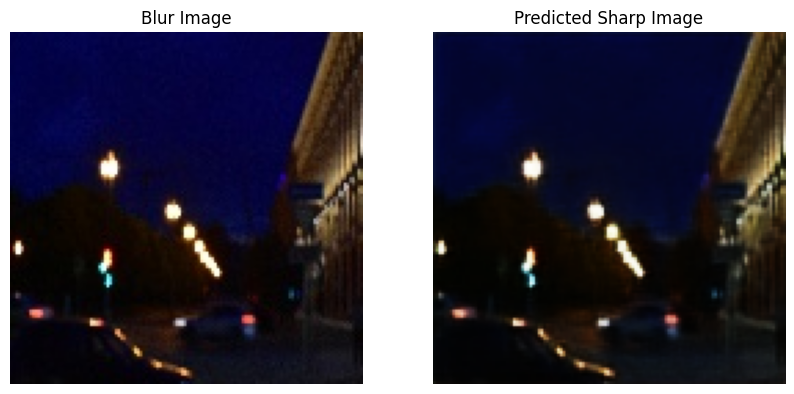

1/1 [==============================] - 0s 23ms/step


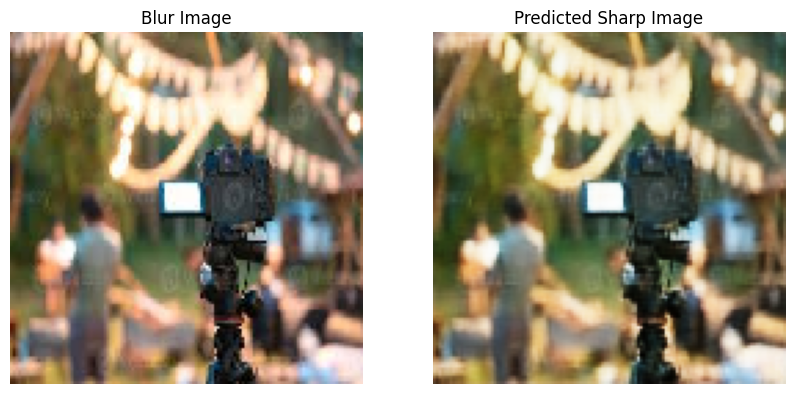

1/1 [==============================] - 0s 28ms/step


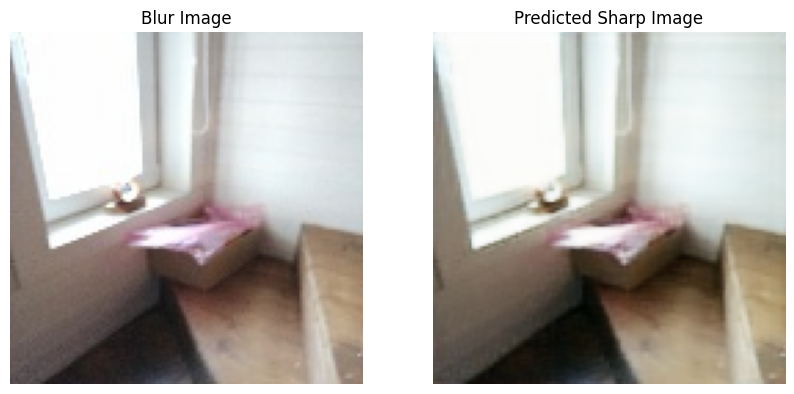

1/1 [==============================] - 0s 24ms/step


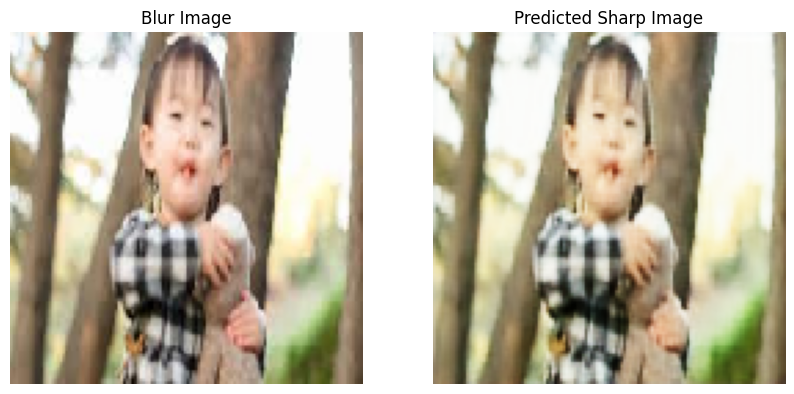

In [ ]:
model = load_model('/content/image-deblur/deblur_model_fold_1.h5')

def deblur_image(img_path, output_path, size=(128, 128)):
    # Load and preprocess the input image
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    deblurred_array = model.predict(img_array)[0]

    # Convert the deblurred array to image and save
    deblurred_img = array_to_img(deblurred_array)

    # Plot both images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Blur Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(deblurred_img)
    plt.title('Predicted Sharp Image')
    plt.axis('off')

    plt.show()

# Example usage
deblur_image('/content/42_NIKON-D3400-35MM_F.JPG', '/content/out.jpg')
deblur_image('/content/images.jpeg', '/content/out.jpg')
deblur_image('/content/52_HONOR-8X_F.jpg', '/content/out.jpg')
deblur_image('/content/Untitled.jpeg', '/content/out.jpg')


In [ ]:
!git clone https://github.com/jiangsutx/SRN-Deblur

Cloning into 'SRN-Deblur'...
remote: Enumerating objects: 69, done.
remote: Total 69 (delta 0), reused 0 (delta 0), pack-reused 69
Receiving objects: 100% (69/69), 11.52 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
cd SRN-Deblur/

/content/SRN-Deblur


In [ ]:
# Install TensorFlow 1.x
!pip install tensorflow==1.4
!pip install scipy
!pip install numpy
!pip install imageio


ERROR: Could not find a version that satisfies the requirement tensorflow==1.4 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==1.4
